In [1]:
import pandas
import urllib.request

data_filename = 'nyc_taxi.csv'
data_source = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

urllib.request.urlretrieve(data_source, data_filename)
taxi_data = pandas.read_csv(data_filename, delimiter=',')
taxi_data.plot(title='Taxi Ridership in NYC')

In [4]:
%%sh 
conda install boto3

Solving environment: ...working... done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/tensorflow_p36

  added / updated specs: 
    - boto3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.4.16          |           py36_0         142 KB

The following packages will be UPDATED:

    certifi:         2018.4.16-py36_0 conda-forge --> 2018.4.16-py36_0 
    openssl:         1.0.2o-0         conda-forge --> 1.0.2o-h20670df_0

The following packages will be DOWNGRADED:

    ca-certificates: 2018.4.16-0      conda-forge --> 2018.03.07-0     

Proceed ([y]/n)? 

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.2

Please update conda by running

    $ conda update -n base conda


certifi 2018.4.16: ########## | 100% 


In [6]:
def convert_and_upload_training_data(
    ndarray, bucket, prefix, filename='data.pbr'):
    import boto3
    import os
    from sagemaker.amazon.common import numpy_to_record_serializer

    # convert Numpy array to Protobuf RecordIO format
    serializer = numpy_to_record_serializer()
    buffer = serializer(ndarray)

    # upload to S3
    s3_object = os.path.join(prefix, 'train', filename)
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(buffer)
    s3_path = 's3://{}/{}'.format(bucket, s3_object)
    return s3_path

bucket = 'gk-sagemaker-test-01' # <-- use your own bucket, here
prefix = 'sagemaker01/randomcutforest01'
s3_train_data = convert_and_upload_training_data(
    taxi_data.value.as_matrix().reshape(-1,1),
    bucket,
    prefix)

In [9]:
import boto3
import sagemaker
containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/randomcutforest:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/randomcutforest:latest'}
region_name = boto3.Session().region_name
container = containers[region_name]

session = sagemaker.Session()

rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    sagemaker_session=session)

rcf.set_hyperparameters(
    num_samples_per_tree=200,
    num_trees=50,
    feature_dim=1) # feature_sizeでは間違い

s3_train_input = sagemaker.session.s3_input(
    s3_train_data,
    distribution='ShardedByS3Key',
    content_type='application/x-recordio-protobuf')

rcf.fit({'train': s3_train_input})

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-05-04-05-01-39-829


.....................................................
Docker entrypoint called with argument(s): train
[05/04/2018 05:05:59 INFO 140190373291840] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'num_samples_per_tree': 256, u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[05/04/2018 05:05:59 INFO 140190373291840] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'1', u'num_samples_per_tree': u'200', u'num_trees': u'50'}
[05/04/2018 05:05:59 INFO 140190373291840] Final configuration: {u'num_samples_per_tree': u'200', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'feature_dim': u'1', u'num_trees': u'50', u'eval_

===== Job Complete =====
Billable seconds: 98


In [10]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.deserializer = json_deserializer


INFO:sagemaker:Creating model with name: randomcutforest-2018-05-04-05-25-43-438
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-05-04-05-01-39-829


--------------------------------------------------------------!

In [11]:
results = rcf_inference.predict(taxi_data.value.as_matrix().reshape(-1,1))
scores = [datum['score'] for datum in results['scores']]
taxi_data['score'] = pandas.Series(scores, index=taxi_data.index)

score_mean = taxi_data.score.mean()
score_std = taxi_data.score.std()

score_cutoff = score_mean + 3*score_std
anomalies = taxi_data[taxi_data['score'] > score_cutoff]

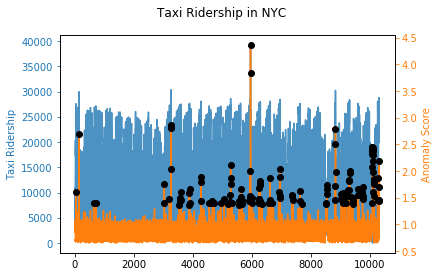

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(taxi_data['value'], alpha=0.8)
ax1.set_ylabel('Taxi Ridership', color='C0')
ax1.tick_params('y', colors='C0')

ax2.plot(taxi_data['score'], color='C1')
ax2.plot(anomalies.index, anomalies.score, 'ko')
ax2.set_ylabel('Anomaly Score', color='C1')
ax2.tick_params('y', colors='C1')

fig.suptitle('Taxi Ridership in NYC')
plt.show()